# Lab 4: Data Imputation using an Autoencoder


In this lab, you will build and train an autoencoder to impute (or "fill in") missing data.

We will be using the
Adult Data Set provided by the UCI Machine Learning Repository [1], available
at https://archive.ics.uci.edu/ml/datasets/adult.
The data set contains census record files of adults, including their
age, martial status, the type of work they do, and other features.

Normally, people use this data set to build a supervised classification
model to classify whether a person is a high income earner.
We will not use the dataset for this original intended purpose.

Instead, we will perform the task of imputing (or "filling in") missing values in the dataset. For example,
we may be missing one person's martial status, and another person's age, and
a third person's level of education. Our model will predict the missing features
based on the information that we do have about each person.

We will use a variation of a denoising autoencoder to solve this data imputation
problem. Our autoencoder will be trained using inputs that have one categorical feature artificially
removed, and the goal of the autoencoder is to correctly reconstruct all features,
including the one removed from the input.

In the process, you are expected to learn to:

1. Clean and process continuous and categorical data for machine learning.
2. Implement an autoencoder that takes continuous and categorical (one-hot) inputs.
3. Tune the hyperparameters of an autoencoder.
4. Use baseline models to help interpret model performance.

[1] Dua, D. and Karra Taniskidou, E. (2017). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.


### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information.

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.


## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link: https://colab.research.google.com/drive/1WQMtTy8iVcfE46wIC5lI8eoTZZqzE-YG?usp=sharing

In [ ]:
import csv
import numpy as np
import random
import torch
import torch.utils.data

## Part 0

We will be using a package called `pandas` for this assignment.

If you are using Colab, `pandas` should already be available.
If you are using your own computer,
installation instructions for `pandas` are available here:
https://pandas.pydata.org/pandas-docs/stable/install.html

In [ ]:
import pandas as pd

# Part 1. Data Cleaning [15 pt]

The adult.data file is available at `https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data`

The function `pd.read_csv` loads the adult.data file into a pandas dataframe.
You can read about the pandas documentation for `pd.read_csv` at
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html

In [ ]:
header = ['age', 'work', 'fnlwgt', 'edu', 'yredu', 'marriage', 'occupation',
 'relationship', 'race', 'sex', 'capgain', 'caploss', 'workhr', 'country']
df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    names=header,
    index_col=False)

<ipython-input-3-037957db2593>:3: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  df = pd.read_csv(


In [ ]:
df.shape # there are 32561 rows (records) in the data frame, and 14 columns (features)

(32561, 14)

### Part (a) Continuous Features [3 pt]

For each of the columns `["age", "yredu", "capgain", "caploss", "workhr"]`, report the minimum, maximum, and average value across the dataset.

Then, normalize each of the features `["age", "yredu", "capgain", "caploss", "workhr"]`
so that their values are always between 0 and 1.
Make sure that you are actually modifying the dataframe `df`.

Like numpy arrays and torch tensors,
pandas data frames can be sliced. For example, we can
display the first 3 rows of the data frame (3 records) below.

In [ ]:
df[:3] # show the first 3 records

,age,work,fnlwgt,edu,yredu,marriage,occupation,relationship,race,sex,capgain,caploss,workhr,country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States


Alternatively, we can slice based on column names,
for example `df["race"]`, `df["hr"]`, or even index multiple columns
like below.

In [ ]:
subdf = df[["age", "yredu", "capgain", "caploss", "workhr"]]
subdf[:3] # show the first 3 records

,age,yredu,capgain,caploss,workhr
0,39,13,2174,0,40
1,50,13,0,0,13
2,38,9,0,0,40


Numpy works nicely with pandas, like below:

In [ ]:
np.sum(subdf["caploss"])

2842700

Just like numpy arrays, you can modify
entire columns of data rather than one scalar element at a time.
For example, the code  

`df["age"] = df["age"] + 1`

would increment everyone's age by 1.

In [ ]:
print("Max age:",df["age"].max())
print("Min age:",df["age"].min())
print("Avgerage age:",df["age"].mean())
print()

print("Max yredu:",df["yredu"].max())
print("Min yredu:",df["yredu"].min())
print("Avgerage yredu:",df["yredu"].mean())
print()

print("Max capgain:",df["capgain"].max())
print("Min capgain:",df["capgain"].min())
print("Avgerage capgain:",df["capgain"].mean())
print()

print("Max caploss:",df["caploss"].max())
print("Min caploss:",df["caploss"].min())
print("Avgerage caploss:",df["caploss"].mean())
print()

print("Max workhr:",df["workhr"].max())
print("Min workhr:",df["workhr"].min())
print("Avgerage workhr:",df["workhr"].mean())

Max age: 90
Min age: 17
Avgerage age: 38.58164675532078

Max yredu: 16
Min yredu: 1
Avgerage yredu: 10.0806793403151

Max capgain: 99999
Min capgain: 0
Avgerage capgain: 1077.6488437087312

Max caploss: 4356
Min caploss: 0
Avgerage caploss: 87.303829734959

Max workhr: 99
Min workhr: 1
Avgerage workhr: 40.437455852092995


In [ ]:
#Normalizing every column using the formula: z = (x – min(x)) / (max(x) – min(x))
df["age"] = (df["age"]-df["age"].min()) / (df["age"].max() - df["age"].min())
df["yredu"] = (df["yredu"]-df["yredu"].min()) / (df["yredu"].max() - df["yredu"].min())
df["capgain"] = (df["capgain"]-df["capgain"].min()) / (df["capgain"].max() - df["capgain"].min())
df["caploss"] = (df["caploss"]-df["caploss"].min()) / (df["caploss"].max() - df["caploss"].min())
df["workhr"] = (df["workhr"]-df["workhr"].min()) / (df["workhr"].max() - df["workhr"].min())

### Part (b) Categorical Features [1 pt]

What percentage of people in our data set are male? Note that the data labels all have an unfortunate space in the beginning, e.g. " Male" instead of "Male".

What percentage of people in our data set are female?

In [ ]:
# hint: you can do something like this in pandas
sum(df["sex"] == " Male")

print("Female percentage in the data set : %.2f%%" %
 ((sum(df["sex"] == " Female") / (sum(df["sex"
 ] == " Female")+sum(df["sex"]== " Male"))) * 100))

Female percentage in the data set : 33.08%


### Part (c) [2 pt]

Before proceeding, we will modify our data frame in a couple more ways:

1. We will restrict ourselves to using a subset of the features (to simplify our autoencoder)
2. We will remove any records (rows) already containing missing values, and store them in a second dataframe. We will only use records without missing values to train our autoencoder.

Both of these steps are done for you, below.

How many records contained missing features? What percentage of records were removed?

In [ ]:
contcols = ["age", "yredu", "capgain", "caploss", "workhr"]
catcols = ["work", "marriage", "occupation", "edu", "relationship", "sex"]
features = contcols + catcols
df = df[features]

In [ ]:
missing = pd.concat([df[c] == " ?" for c in catcols], axis=1).any(axis=1)
df_with_missing = df[missing]
df_not_missing = df[~missing]

In [ ]:
print("The number of records contained missing features: ", len(df_with_missing))
print(("The percentage of records that were removed: %.2f%%") % (len(df_with_missing)/(len(df_with_missing) + len(df_not_missing)) *100))

The number of records contained missing features:  1843
The percentage of records that were removed: 5.66%


### Part (d) One-Hot Encoding [1 pt]

What are all the possible values of the feature "work" in `df_not_missing`? You may find the Python function `set` useful.

In [ ]:
set(df_not_missing["work"])

{' Federal-gov',
 ' Local-gov',
 ' Private',
 ' Self-emp-inc',
 ' Self-emp-not-inc',
 ' State-gov',
 ' Without-pay'}

We will be using a one-hot encoding to represent each of the categorical variables.
Our autoencoder will be trained using these one-hot encodings.

We will use the pandas function `get_dummies` to produce one-hot encodings
for all of the categorical variables in `df_not_missing`.

In [ ]:
data = pd.get_dummies(df_not_missing)

In [ ]:
data[:3]

,age,yredu,capgain,caploss,workhr,work_ Federal-gov,work_ Local-gov,work_ Private,work_ Self-emp-inc,work_ Self-emp-not-inc,...,edu_ Prof-school,edu_ Some-college,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,sex_ Female,sex_ Male
0,0.301370,0.800000,0.02174,0.0,0.397959,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
1,0.452055,0.800000,0.00000,0.0,0.122449,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1
2,0.287671,0.533333,0.00000,0.0,0.397959,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1


### Part (e) One-Hot Encoding [2 pt]

The dataframe `data` contains the cleaned and normalized data that we will use to train our denoising autoencoder.

How many **columns** (features) are in the dataframe `data`?

Briefly explain where that number come from.

In [ ]:
print("Number of columns in this datafram is: ", len(data.columns))
#The number of columns is the number of features which came from the number of features
#that are not missing values (which are all stored in the dataframe "data").

Number of columns in this datafram is:  57


### Part (f) One-Hot Conversion [3 pt]

We will convert the pandas data frame `data` into numpy, so that
it can be further converted into a PyTorch tensor.
However, in doing so, we lose the column label information that
a panda data frame automatically stores.

Complete the function `get_categorical_value` that will return
the named value of a feature given a one-hot embedding.
You may find the global variables `cat_index` and `cat_values`
useful. (Display them and figure out what they are first.)

We will need this function in the next part of the lab
to interpret our autoencoder outputs. So, the input
to our function `get_categorical_values` might not
actually be "one-hot" -- the input may instead
contain real-valued predictions from our neural network.

In [ ]:
datanp = data.values.astype(np.float32)

In [ ]:
cat_index = {}  # Mapping of feature -> start index of feature in a record
cat_values = {} # Mapping of feature -> list of categorical values the feature can take

# build up the cat_index and cat_values dictionary
for i, header in enumerate(data.keys()):
    if "_" in header: # categorical header
        feature, value = header.split()
        feature = feature[:-1] # remove the last char; it is always an underscore
        if feature not in cat_index:
            cat_index[feature] = i
            cat_values[feature] = [value]
        else:
            cat_values[feature].append(value)

def get_onehot(record, feature):
    """
    Return the portion of `record` that is the one-hot encoding
    of `feature`. For example, since the feature "work" is stored
    in the indices [5:12] in each record, calling `get_range(record, "work")`
    is equivalent to accessing `record[5:12]`.

    Args:
        - record: a numpy array representing one record, formatted
                  the same way as a row in `data.np`
        - feature: a string, should be an element of `catcols`
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    return record[start_index:stop_index]

def get_categorical_value(onehot, feature):
    """
    Return the categorical value name of a feature given
    a one-hot vector representing the feature.

    Args:
        - onehot: a numpy array one-hot representation of the feature
        - feature: a string, should be an element of `catcols`

    Examples:

    >>> get_categorical_value(np.array([0., 0., 0., 0., 0., 1., 0.]), "work")
    'State-gov'
    >>> get_categorical_value(np.array([0.1, 0., 1.1, 0.2, 0., 1., 0.]), "work")
    'Private'
    """
    # <----- TODO: WRITE YOUR CODE HERE ----->
    # You may find the variables `cat_index` and `cat_values`
    # (created above) useful.

    #
    value_name = cat_values[feature][np.argmax(onehot)]

    return value_name


In [ ]:
# more useful code, used during training, that depends on the function
# you write above

def get_feature(record, feature):
    """
    Return the categorical feature value of a record
    """
    onehot = get_onehot(record, feature)
    return get_categorical_value(onehot, feature)

def get_features(record):
    """
    Return a dictionary of all categorical feature values of a record
    """
    return { f: get_feature(record, f) for f in catcols }

### Part (g) Train/Test Split [3 pt]

Randomly split the data into approximately 70% training, 15% validation and 15% test.

Report the number of items in your training, validation, and test set.

In [ ]:
# set the numpy seed for reproducibility
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.seed.html
np.random.seed(50)

# todo

np.random.shuffle(datanp)

indice = datanp.shape[0]

train_set = datanp[:int(indice*0.7)]
val_set = datanp[int(indice*0.7):int(indice*0.85)]
test_set = datanp[int(indice*0.85):]
print("# Train Set: ", len(train_set))
print("# Test Set: ", len(val_set))
print("# Val Set: ", len(test_set))

# Train Set:  21502
# Test Set:  4608
# Val Set:  4608


## Part 2. Model Setup [5 pt]

### Part (a) [4 pt]

Design a fully-connected autoencoder by modifying the `encoder` and `decoder`
below.

The input to this autoencoder will be the features of the `data`, with
one categorical feature recorded as "missing". The output of the autoencoder
should be the reconstruction of the same features, but with the missing
value filled in.

**Note**: Do not reduce the dimensionality of the input too much!
The output of your embedding is expected to contain information
about ~11 features.

In [ ]:
from torch import nn

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.name = "AutoEncoder"
        self.encoder = nn.Sequential(
            nn.Linear(57, 37), # TODO -- FILL OUT THE CODE HERE!
            nn.ReLU(),
            nn.Linear(37,27),
            nn.ReLU(),
            nn.Linear(27,17)
        )
        self.decoder = nn.Sequential(
            nn.Linear(17, 27), # TODO -- FILL OUT THE CODE HERE!
            nn.ReLU(),
            nn.Linear(27,37),
            nn.ReLU(),
            nn.Linear(37,57),
            nn.Sigmoid() # get to the range (0, 1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### Part (b) [1 pt]

Explain why there is a sigmoid activation in the last step of the decoder.

(**Note**: the values inside the data frame `data` and the training code in Part 3 might be helpful.)

In [ ]:
#The sigmoid activation as the last step of the decoder is to ensure that
#the output constructed by the decoder is between the range of 0 to 1
#since the previously we have normalized the data.

## Part 3. Training [18]

### Part (a) [6 pt]

We will train our autoencoder in the following way:

- In each iteration, we will hide one of the categorical features using the `zero_out_random_features` function
- We will pass the data with one missing feature through the autoencoder, and obtain a reconstruction
- We will check how close the reconstruction is compared to the original data -- including the value of the missing feature

Complete the code to train the autoencoder, and plot the training and validation loss every few iterations.
You may also want to plot training and validation "accuracy" every few iterations, as we will define in
part (b). You may also want to checkpoint your model every few iterations or epochs.

Use `nn.MSELoss()` as your loss function. (Side note: you might recognize that this loss function is not
ideal for this problem, but we will use it anyway.)

In [ ]:
def zero_out_feature(records, feature):
    """ Set the feature missing in records, by setting the appropriate
    columns of records to 0
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    records[:, start_index:stop_index] = 0
    return records

def zero_out_random_feature(records):
    """ Set one random feature missing in records, by setting the
    appropriate columns of records to 0
    """
    return zero_out_feature(records, random.choice(catcols))

def train(model, train_loader, valid_loader, batch_size = 64, num_epochs=5, learning_rate=1e-4):
    """ Training loop. You should update this."""
    torch.manual_seed(42)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_acc, train_loss, val_acc, val_loss = [], [], [], []

    for epoch in range(num_epochs):
        total_loss = 0
        i=0
        for data in train_loader:
            datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
            recon = model(datam)
            loss = criterion(recon, data)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            total_loss += loss.item()
            i+=1

        train_epoch_acc = get_accuracy(model, train_loader)
        train_acc.append(train_epoch_acc)

        val_epoch_acc = get_accuracy(model, valid_loader)
        val_acc.append(val_epoch_acc)

        train_loss.append(total_loss / (i + 1))
        val_loss.append(evaluate(model, valid_loader, criterion))


        print(("Epoch {}: Train Acc: {}, Train Loss: {} |"+
               "Validation Acc: {}, Validation Loss: {}").format(
                   epoch + 1,
                   train_acc[epoch],
                   train_loss[epoch],
                   val_acc[epoch],
                   val_loss[epoch]))

        # Save the current model (checkpoint) to a file
        model_path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(model.name, batch_size, learning_rate, epoch)
        torch.save(model.state_dict(), model_path)

    return train_acc, train_loss, val_acc, val_loss

### Part (b) [3 pt]

While plotting training and validation loss is valuable, loss values are harder to compare
than accuracy percentages. It would be nice to have a measure of "accuracy" in this problem.

Since we will only be imputing missing categorical values, we will define an accuracy measure.
For each record and for each categorical feature, we determine whether
the model can predict the categorical feature given all the other features of the record.

A function `get_accuracy` is written for you. It is up to you to figure out how to
use the function. **You don't need to submit anything in this part.**
To earn the marks, correctly plot the training and validation accuracy every few
iterations as part of your training curve.

In [ ]:
def get_accuracy(model, data_loader):
    """Return the "accuracy" of the autoencoder model across a data set.
    That is, for each record and for each categorical feature,
    we determine whether the model can successfully predict the value
    of the categorical feature given all the other features of the
    record. The returned "accuracy" measure is the percentage of times
    that our model is successful.

    Args:
       - model: the autoencoder model, an instance of nn.Module
       - data_loader: an instance of torch.utils.data.DataLoader

    Example (to illustrate how get_accuracy is intended to be called.
             Depending on your variable naming this code might require
             modification.)

        >>> model = AutoEncoder()
        >>> vdl = torch.utils.data.DataLoader(data_valid, batch_size=256, shuffle=True)
        >>> get_accuracy(model, vdl)
    """
    total = 0
    acc = 0

    for col in catcols:
        for item in data_loader: # minibatches
            inp = item.detach().numpy()
            out = model(zero_out_feature(item.clone(), col)).detach().numpy()
            for i in range(out.shape[0]): # record in minibatch
                acc += int(get_feature(out[i], col) == get_feature(inp[i], col))
                total += 1
    return acc / total

def evaluate(model, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         model: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0
    i=0

    for data in train_loader:
        datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
        recon = model(datam)
        loss = criterion(recon, data)
        loss.backward()

        total_loss += loss.item()
        i+=1

    loss = float(total_loss) / (i + 1)

    return loss

### Part (c) [4 pt]

Run your updated training code, using reasonable initial hyperparameters.

Include your training curve in your submission.

Epoch 1: Train Acc: 0.5360431587759278, Train Loss: 0.08868198020477677 |Validation Acc: 0.5389178240740741, Validation Loss: 0.056579438411252084
Epoch 2: Train Acc: 0.5507007100114718, Train Loss: 0.05675296249968008 |Validation Acc: 0.5502387152777778, Validation Loss: 0.05424867934085849
Epoch 3: Train Acc: 0.5718227761758596, Train Loss: 0.05298749110951622 |Validation Acc: 0.5727358217592593, Validation Loss: 0.0514045757095078
Epoch 4: Train Acc: 0.5851781229653056, Train Loss: 0.05396122524089205 |Validation Acc: 0.5822482638888888, Validation Loss: 0.049288342300614546
Epoch 5: Train Acc: 0.5863020494217592, Train Loss: 0.0493256059815162 |Validation Acc: 0.5828993055555556, Validation Loss: 0.04754375471824708
Epoch 6: Train Acc: 0.5942315443524634, Train Loss: 0.04657418734065149 |Validation Acc: 0.5903139467592593, Validation Loss: 0.04457210966051509
Epoch 7: Train Acc: 0.5969289678479521, Train Loss: 0.04459636952473785 |Validation Acc: 0.5929181134259259, Validation Loss

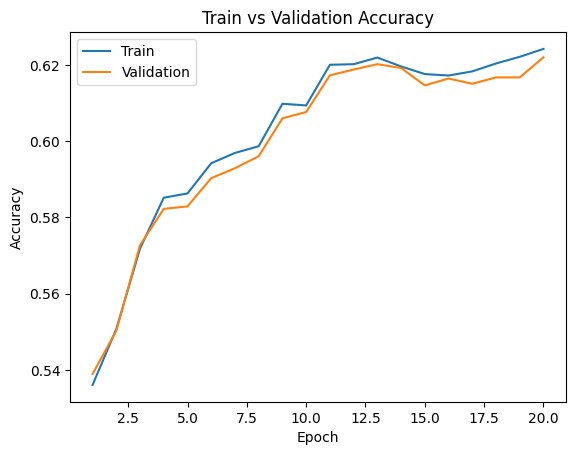

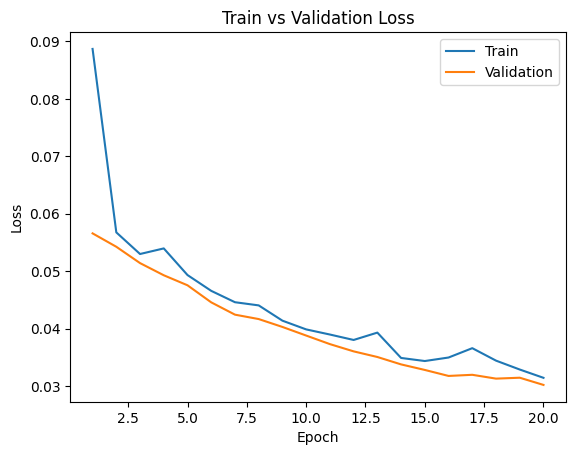

In [ ]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=64, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, num_workers=2)

autoencoder = AutoEncoder()

train_acc, train_loss, val_acc, val_loss = train(autoencoder, train_loader, val_loader,
                                                 batch_size = 64, num_epochs=20, learning_rate=1e-3)

import matplotlib.pyplot as plt
plt.title("Train vs Validation Accuracy")
n = len(train_acc) # number of epochs
plt.plot(range(1,n+1), train_acc, label="Train")
plt.plot(range(1,n+1), val_acc, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.show()
plt.title("Train vs Validation Loss")
plt.plot(range(1,n+1), train_loss, label="Train")
plt.plot(range(1,n+1), val_loss, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()

### Part (d) [5 pt]

Tune your hyperparameters, training at least 4 different models (4 sets of hyperparameters).

Do not include all your training curves. Instead, explain what hyperparameters
you tried, what their effect was, and what your thought process was as you
chose the next set of hyperparameters to try.

In [ ]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=64, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, num_workers=2)

autoencoder1 = AutoEncoder()

#Since the original parameter showed good performance, I wanted to try increasing th batch_size
#without changing the number of epochs. Therefore I changed the batch size to be 128
#instead of 64 that was previously used.
train_acc1, train_loss1, val_acc1, val_loss1 = train(autoencoder1, train_loader,
                                                     val_loader, batch_size = 128, num_epochs=20,
                                                     learning_rate=1e-3)

print()
print("Train Accuracy: ", train_acc1[-1])
print("Train Loss: ", train_loss1[-1])
print("Validation Accuracy: ",val_acc1[-1])
print("Validation Loss: ",val_loss1[-1])

#The effect of the model is very minimal and the accuracy of the training
#and validation is less accurate by about 1%.

Epoch 1: Train Acc: 0.47518060335472667, Train Loss: 0.08945947033228789 |Validation Acc: 0.4749710648148148, Validation Loss: 0.06456304827942692
Epoch 2: Train Acc: 0.5566768982730289, Train Loss: 0.057744183630104945 |Validation Acc: 0.5587022569444444, Validation Loss: 0.05465691075701742
Epoch 3: Train Acc: 0.5703345425231762, Train Loss: 0.053943065478734516 |Validation Acc: 0.5696976273148148, Validation Loss: 0.05196126382411057
Epoch 4: Train Acc: 0.5737373267603013, Train Loss: 0.05135595497816182 |Validation Acc: 0.5716145833333334, Validation Loss: 0.047692965108138516
Epoch 5: Train Acc: 0.5870926735497473, Train Loss: 0.04743737416778545 |Validation Acc: 0.5840205439814815, Validation Loss: 0.04367919202109119
Epoch 6: Train Acc: 0.5969987288004217, Train Loss: 0.04363647756617218 |Validation Acc: 0.5966073495370371, Validation Loss: 0.040938884196720066
Epoch 7: Train Acc: 0.592363501069668, Train Loss: 0.04397641217407911 |Validation Acc: 0.5921947337962963, Validation 

In [ ]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=64, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, num_workers=2)

autoencoder2 = AutoEncoder()

#Next I thought of changing the learning rate to be smaller (to 1e-4 instead of 1e-3)
#but the batch size is left as 128 as I do not want the batch size to be too small
#since this may lead to overfitting.
train_acc2, train_loss2, val_acc2, val_loss2 = train(autoencoder2, train_loader,
                                                     val_loader, batch_size = 128,
                                                     num_epochs=20, learning_rate=1e-4)

print()
print("Train Accuracy: ", train_acc2[-1])
print("Train Loss: ", train_loss2[-1])
print("Validation Accuracy: ",val_acc2[-1])
print("Validation Loss: ",val_loss2[-1])
#The effect of this change did not increased the accuracy but significantly decreased the accuracy
#for both training and validation. Therefore, this set of hyperparameters are not as good,
#and should look into modifying epochs and batch size instead of learning rate.

Epoch 1: Train Acc: 0.4335333147304127, Train Loss: 0.19743713906769936 |Validation Acc: 0.4320023148148148, Validation Loss: 0.08761355389208043
Epoch 2: Train Acc: 0.4335333147304127, Train Loss: 0.08121960309475042 |Validation Acc: 0.4320023148148148, Validation Loss: 0.07944965004390354
Epoch 3: Train Acc: 0.4335333147304127, Train Loss: 0.07641405877532874 |Validation Acc: 0.4320023148148148, Validation Loss: 0.07561441062112237
Epoch 4: Train Acc: 0.45940687687967013, Train Loss: 0.07399885332106837 |Validation Acc: 0.4583333333333333, Validation Loss: 0.07351246818855892
Epoch 5: Train Acc: 0.45940687687967013, Train Loss: 0.07255119963021237 |Validation Acc: 0.4583333333333333, Validation Loss: 0.07228689256071691
Epoch 6: Train Acc: 0.45940687687967013, Train Loss: 0.07170557818798354 |Validation Acc: 0.4583333333333333, Validation Loss: 0.0715509807851265
Epoch 7: Train Acc: 0.45940687687967013, Train Loss: 0.07122861209272985 |Validation Acc: 0.4583333333333333, Validation L

In [ ]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=64, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, num_workers=2)

autoencoder3 = AutoEncoder()

#The new set of hyperparameters I changed the learning rate back
#and made the batch size back to 64 in order to test the effect of epochs on the model.
#Instead of num_epochs = 20, I increased it to 50 instead.
train_acc3, train_loss3, val_acc3, val_loss3 = train(autoencoder3, train_loader,
                                                     val_loader, batch_size = 64,
                                                     num_epochs=50, learning_rate=1e-3)

print()
print("Train Accuracy: ", train_acc3[-1])
print("Train Loss: ", train_loss3[-1])
print("Validation Accuracy: ",val_acc3[-1])
print("Validation Loss: ",val_loss3[-1])
#This significantly increased compared to the previous set of hyperparameters,
#which demonstrated that the number of epochs has more significant impacts
#on the effects.

Epoch 1: Train Acc: 0.45772486280346014, Train Loss: 0.08943309302190292 |Validation Acc: 0.45710358796296297, Validation Loss: 0.06652570555666434
Epoch 2: Train Acc: 0.562149257433417, Train Loss: 0.057897719181521354 |Validation Acc: 0.5609447337962963, Validation Loss: 0.05278151797390479
Epoch 3: Train Acc: 0.571473971413512, Train Loss: 0.05682762933325697 |Validation Acc: 0.5707103587962963, Validation Loss: 0.05315100819491491
Epoch 4: Train Acc: 0.5948826465755124, Train Loss: 0.050282981600446586 |Validation Acc: 0.5916883680555556, Validation Loss: 0.04605302998370516
Epoch 5: Train Acc: 0.5955570024493846, Train Loss: 0.04358117015982594 |Validation Acc: 0.5929904513888888, Validation Loss: 0.04127855150123025
Epoch 6: Train Acc: 0.5953322171580938, Train Loss: 0.042653852526529604 |Validation Acc: 0.5943287037037037, Validation Loss: 0.03873538034650268
Epoch 7: Train Acc: 0.59859547949028, Train Loss: 0.04002005599151733 |Validation Acc: 0.5953414351851852, Validation Los

In [ ]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=64, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, num_workers=2)

autoencoder4 = AutoEncoder()

#After trying to increase num_epochs = 50 and seeing positive feedback, I tried
#to increase the batch size to 128 instead of 64 from last one to see if this
#would show similar result like it previously did when we were testing with 20 epochs.
train_acc4, train_loss4, val_acc4, val_loss4 = train(autoencoder4, train_loader,
                                                     val_loader, batch_size = 128,
                                                     num_epochs=50, learning_rate=1e-3)

print()
print("Train Accuracy: ", train_acc4[-1])
print("Train Loss: ", train_loss4[-1])
print("Validation Accuracy: ",val_acc4[-1])
print("Validation Loss: ",val_loss4[-1])
#The model showed pretty good performance compared to most of the other ones,
#however, the previous set of hyperparameters when batch size is 64 still seem to be about
#1% higher in accuracy.

Epoch 1: Train Acc: 0.5417403032276067, Train Loss: 0.0856533811292238 |Validation Acc: 0.5437282986111112, Validation Loss: 0.05591444337314951
Epoch 2: Train Acc: 0.5718925371283291, Train Loss: 0.056102720031221825 |Validation Acc: 0.5736762152777778, Validation Loss: 0.05275472582978381
Epoch 3: Train Acc: 0.5850618547111897, Train Loss: 0.05117125596950599 |Validation Acc: 0.5826822916666666, Validation Loss: 0.04531441276301616
Epoch 4: Train Acc: 0.5931851300654203, Train Loss: 0.04388533870880257 |Validation Acc: 0.5917245370370371, Validation Loss: 0.042282500246246774
Epoch 5: Train Acc: 0.5940997736644653, Train Loss: 0.043339846694416394 |Validation Acc: 0.5956669560185185, Validation Loss: 0.040384884724719586
Epoch 6: Train Acc: 0.6020370198121106, Train Loss: 0.03972846370201436 |Validation Acc: 0.6023220486111112, Validation Loss: 0.038524483261458596
Epoch 7: Train Acc: 0.6030136731466841, Train Loss: 0.03873697895479308 |Validation Acc: 0.6014901620370371, Validation 

## Part 4. Testing [12 pt]

### Part (a) [2 pt]

Compute and report the test accuracy.

In [ ]:
model_path = "model_AutoEncoder_bs64_lr0.001_epoch49"
state = torch.load(model_path)
autoencoder.load_state_dict(state)
test_acc = get_accuracy(autoencoder, test_loader)
print(("Test accuracy for the best model is: %f%%")%(test_acc*100))

Test accuracy for the best model is: 63.744213%


### Part (b) [4 pt]

Based on the test accuracy alone, it is difficult to assess whether our model
is actually performing well. We don't know whether a high accuracy is due to
the simplicity of the problem, or if a poor accuracy is a result of the inherent
difficulty of the problem.

It is therefore very important to be able to compare our model to at least one
alternative. In particular, we consider a simple **baseline**
model that is not very computationally expensive. Our neural network
should at least outperform this baseline model. If our network is not much
better than the baseline, then it is not doing well.

For our data imputation problem, consider the following baseline model:
to predict a missing feature, the baseline model will look at the **most common value** of the feature in the training set.

For example, if the feature "marriage" is missing, then this model's prediction will be the most common value for "marriage" in the training set, which happens to be "Married-civ-spouse".

What would be the test accuracy of this baseline model?


In [ ]:
modes = get_features(train_set.sum(axis=0))

total_correct = 0.0
for record in test_set:
    test_val = get_features(record)

    for item in modes:
        if modes[item] == test_val[item]:
            total_correct += 1

accuracy = total_correct / (len(test_set)*len(catcols))

print(("Test accuracy for baseline model: %f%%")%(accuracy*100))


Test accuracy for baseline model: 45.685041%


### Part (c) [1 pt]

How does your test accuracy from part (a) compared to your basline test accuracy in part (b)?

In [ ]:
#The test accuracy from part a is higher than the baseline test accuracy by aroud 17%
#as part a)'s accuracy on testing was around 63.7% and the part b) accuracy on testing
#for the baseline model is around 45.7%.

### Part (d) [1 pt]

Look at the first item in your test data.
Do you think it is reasonable for a human
to be able to guess this person's education level
based on their other features? Explain.

In [ ]:
print(get_features(test_set[0]))

#It may not be hard for humans to guess based on this peron specifically.
#Professional specialty occupations meaning that the person has received specialized
#training in the field that they are working in, which a minimum of a bachelor's degree
#would make sense for a person at this position.
#Althought it is not always easy to guess other's education level with their occupation,
#based on the specific case it is fine.

{'work': 'Private', 'marriage': 'Divorced', 'occupation': 'Prof-specialty', 'edu': 'Bachelors', 'relationship': 'Not-in-family', 'sex': 'Male'}


### Part (e) [2 pt]

What is your model's prediction of this person's education
level, given their other features?


In [ ]:
specific_test = torch.tensor(test_set[0],dtype=torch.float32)

model_path = "model_AutoEncoder_bs64_lr0.001_epoch49"
state = torch.load(model_path)
autoencoder.load_state_dict(state)

autoencoder=AutoEncoder()

pred = get_feature(autoencoder(specific_test).detach().numpy(), "edu")
print("The prediction is: ", pred)

The prediction is:  Some-college


### Part (f) [2 pt]

What is the baseline model's prediction
of this person's education level?

In [ ]:
print(modes["edu"])
#The baseline model predicts based on the most common values from training set,
#therefore, for education level, the baseline model would give the answer of HS-grad,
#which is not as accurate as the autoencoder.

HS-grad
